# Likelihood Analysis with fermipy

The python likelihood tools are a very powerful set of analysis tools that expand upon the command line tools provided with the Fermi Science Tools package. Not only can you perform all of the same likelihood analysis with the python tools that you can with the standard command line tools but you can directly access all of the model parameters. You can more easily script a standard analysis. There are also a few things built into the python tools that are not available from the command line like the calculation of upper limits.

There are many user contributed packages built upon the python backbone of the Science Tools and this thread will highlight the use of the [fermipy](http://fermipy.readthedocs.org) package.


This sample analysis is based on the PG 1553+113 analysis performed by the LAT team and described in [Abdo, A. A. et al. 2010, ApJ, 708, 1310](http://adsabs.harvard.edu/abs/2010ApJ...708.1310A). This tutorial assumes you have the most recent ScienceTools installed and [fermipy](http://fermipy.readthedocs.org) installed on top of it. We will also make significant use of python, so you might want to familiarize yourself with python including matplotlib and other libraries (there's a beginner's guide at http://wiki.python.org/moin/BeginnersGuide). This tutorial also assumes that you've gone through the non-python based unbinned likelihood thread. 

## Get the Data

For this thread the original data were extracted from the [LAT data server](http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections (these selections are similar to those in the paper):

* Search Center (RA,Dec) = (238.929,11.1901)
* Radius = 30 degrees
* Start Time (MET) = 239557417 seconds (2008-08-04T15:43:37)
* Stop Time (MET) = 256970880 seconds (2009-02-22T04:48:00)
* Minimum Energy = 100 MeV
* Maximum Energy = 300000 MeV

Once you exectute the query you can download the data and put it in your working directory.  You'll need to change the names of the files to match the filenames that the data server gave you.  Alternatively you can run with the following tarball which already contains the downloaded files as well as all of the ancillary files that will be generated for the analysis.

In [1]:
!wget -nc http://www.slac.stanford.edu/~mdwood/fermipy/pg1553.tar.gz
# Alternative download link
# wget -nc https://www.dropbox.com/s/heeft4xx0ibfk8c/pg1553.tar.gz
!tar xzf pg1553.tar.gz

File ‘pg1553.tar.gz’ already there; not retrieving.



### Make a file list

You'll then need to make a file list with the names of your input event files. You can either just make one with a text editor or do the following from the command line.

In [4]:
!ls -1 *PH*.fits > PG1553.lst

## Make a config file

fermipy bases its analysis on a configuration file (in [yaml](http://yaml.org) format).  We're just going to use a really simple config file for a standard analysis.  There are many many more options which you can use or you can modify these options after the fact within the analysis chain.


Make a config file named 'config.yaml' like the following.  For more details on the config file see [config.html](http://fermipy.readthedocs.org/en/latest/config.html).  You will probably need to customize this a bit since your files might not be in the same place or named the same.  The galactic and isotropic diffuse will need to be located on your system (they are included in the science tools or can be downloaded from the FSSC).  In the following example we set the path to these files with the environment variable FERMI_DIFFUSE_DIR.  If FERMI_DIFFUSE_DIR is not defined fermipy will look for the location of these files within the FSSC STs distribution. 

In [1]:
ls config.yaml

config.yaml


## Start the analysis

Next, you create an analysis script and run the setup steps which include running the selections and generating exposure maps etc.  This will take a bit.

This is where the magic happens.  fermipy will load the point source model, create your xml file for you, decide on all the appropriate cuts and binnings and just go.  All of this is configurable from python or from the config file.  And, if you need to rerun things, it's smart enough to not overwrite files if it doesn't need to.

### Load up some useful modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Import the GTAnalysis module from fermipy

You start by importing the module and then creating an instance of the analysis object from our config file.  When instantiating the analysis object we can override any options defined in the configuration file by passing keyword arguments to the object constructor.  Here we explicitly set the verbosity parameter to 3 (INFO) which supresses DEBUG output.  When we create the object, it spits out a bunch of information about all of the parameters that were used.  You can see there are many more options than the ones we chose.

In [5]:
from fermipy.gtanalysis import GTAnalysis

In [6]:
gta = GTAnalysis('pg1553/config.yaml',logging={'verbosity': 3})

2015-11-14 19:16:16 - GTAnalysis - INFO - 
--------------------------------------------------------------------------------
This is fermipy version 0.5.0-30-g43fc-dirty.
2015-11-14 19:16:16 - GTAnalysis - INFO - Configuration:
binning:
  binsperdec: 8
  binsz: 0.1
  coordsys: CEL
  enumbins: null
  npix: null
  proj: AIT
  roiwidth: 10.0
components: []
data:
  evfile: PG1553.lst
  ltcube: null
  scfile: L1511031432171D651E7F63_SC00.fits
extension:
  fix_background: false
  save_model_map: false
  save_templates: false
  spatial_model: GaussianSource
  width: null
  width_max: 1.0
  width_min: 0.01
  width_nstep: 21
fileio:
  logfile: /Users/mdwood/fermi/fermipy/notebooks/pg1553/fermipy
  outdir: /Users/mdwood/fermi/fermipy/notebooks/pg1553
  savefits: true
  scratchdir: /scratch
  usescratch: false
  workdir: null
gtlike:
  bexpmap: null
  convolve: true
  edisp: true
  edisp_disable:
  - isodiff
  - galdiff
  irfs: P8R2_SOURCE_V6
  likelihood: binned
  minbinsz: 0.05
  resample: true


### The setup routine

This gets everything ready for the likelihood analysis including instantiating the pylikelihood object.

In [7]:
gta.setup()

2015-11-14 19:18:44 - GTAnalysis - INFO - Running setup
2015-11-14 19:18:44 - GTBinnedAnalysis - INFO - Running setup for Analysis Component: 00
2015-11-14 19:18:49 - GTBinnedAnalysis - INFO - Finished setup for Analysis Component: 00
2015-11-14 19:19:06 - GTAnalysis - INFO - Finished setup


We can now inspect the state of the ROI prior with the print_roi() method.

In [42]:
gta.print_roi()

name                SpatialModel   SpectrumType     offset        ts       Npred
--------------------------------------------------------------------------------
3FGL J1555.7+1111   PointSource    LogParabola       0.000       nan       923.2
3FGL J1553.5+1256   PointSource    LogParabola       1.833       nan       655.4
3FGL J1603.7+1106   PointSource    PowerLaw          1.976       nan       122.7
3FGL J1552.1+0852   PointSource    PowerLaw          2.482       nan        90.2
3FGL J1608.6+1029   PointSource    PowerLaw          3.252       nan       531.6
3FGL J1541.8+1105   PointSource    PowerLaw          3.411       nan       155.4
3FGL J1546.0+0818   PointSource    PowerLaw          3.753       nan        38.6
3FGL J1548.4+1455   PointSource    PowerLaw          4.134       nan       187.8
3FGL J1541.6+1414   PointSource    PowerLaw          4.596       nan        34.4
3FGL J1611.9+1404   PointSource    PowerLaw          4.888       nan        81.2
3FGL J1540.8+1449   PointSou

Additional details about an individual source can be retrieved by printing the corresponding source object.  Here we use the bracket operator to return the properties of PG1553. 

In [43]:
print(gta.roi['3FGL J1555.7+1111'])

Name           : 3FGL J1555.7+1111
Associations   : ['3FGL J1555.7+1111', 'PG 1553+113', '1FHL J1555.7+1111', '2FGL J1555.7+1111']
RA/DEC         :    238.936/    11.194
GLON/GLAT      :     21.918/    43.960
TS             : nan
Npred          : 923.16
SpatialModel   : PointSource
SpectralType   : LogParabola
Spectral Parameters
alpha          :      1.604 +/-        nan
beta           :    0.03884 +/-        nan
norm           :  4.825e-12 +/-        nan
Eb             :       1491 +/-        nan


## Do the likelihood fitting

Now that all of the ancillary files have been generated, we can move on to the actual fitting.  The first thing you should do is free some of the sources since all of the sources are initially fixed.  We'll just free those sources in the center region.

In [44]:
# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('galdiff')
gta.free_source('isodiff')

In this simple anlaysis we are leaving the spectral shapes of sources fixed but we're going to free the spectral shape of the source we care about.  

In [45]:
gta.free_source('3FGL J1555.7+1111')

Now, actually do the fit.  The software does its best to get the fit to converge by running the fit several times.

In [46]:
gta.fit()

3

We can inspect the results of the fit by printing the source object for PG1553.

In [47]:
print(gta.roi['3FGL J1555.7+1111'])

Name           : 3FGL J1555.7+1111
Associations   : ['3FGL J1555.7+1111', 'PG 1553+113', '1FHL J1555.7+1111', '2FGL J1555.7+1111']
RA/DEC         :    238.936/    11.194
GLON/GLAT      :     21.918/    43.960
TS             : 3003.96
Npred          : 1117.70
SpatialModel   : PointSource
SpectralType   : LogParabola
Spectral Parameters
alpha          :      1.532 +/-    0.05066
beta           :    0.04372 +/-    0.01761
norm           :  6.117e-12 +/-  3.069e-13
Eb             :       1491 +/-        nan


You can then save the state of the roi to a yaml (and npl) file for reference later.  The write_roi function does this.  The first argument is a string that will be prepended to the names of the output files generated by this method.

In [11]:
gta.write_roi('fit0')

2015-11-14 18:47:57 - GTBinnedAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/pg1553/fit0_00.xml...
2015-11-14 18:47:57 - GTBinnedAnalysis - INFO - Generating model map for component 00.
2015-11-14 18:48:02 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/pg1553/fit0.yaml...
2015-11-14 18:48:03 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/pg1553/fit0.npy...
        Use the `.cards` attribute instead. [pywcsgrid2.wcs_helper]
        Use the `.cards` attribute instead.
        Use the `.keyword` attribute instead. [pywcsgrid2.wcs_helper]
        Use the `.keyword` attribute instead.
        Use the `.keyword` attribute instead. [pywcsgrid2.wcs_helper]
        Use the `.keyword` attribute instead.
        Use the `.keyword` attribute instead. [pywcsgrid2.wcs_helper]
        Use the `.keyword` attribute instead.
        Use :meth:`Header.append` instead. [pywcsgrid2.wcs_helper]
        Use :meth:`Header.append` instead.
        Use 

There are a lot of diagnostic plots also saved at the same time.  

In [14]:
ls -l pg1553/*.png

-rw-r--r--  1 mdwood  staff  73146 Nov 14 18:48 pg1553/fit0_counts_map_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  34726 Nov 14 18:48 pg1553/fit0_counts_map_comp_xproj_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  35979 Nov 14 18:48 pg1553/fit0_counts_map_comp_yproj_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  39970 Nov 14 18:48 pg1553/fit0_counts_map_xproj_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  40943 Nov 14 18:48 pg1553/fit0_counts_map_yproj_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  93604 Nov 14 18:48 pg1553/fit0_counts_spectrum.png
-rw-r--r--  1 mdwood  staff  65358 Nov 14 18:48 pg1553/fit0_model_map_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  65358 Nov 14 18:48 pg1553/fit0_model_map_2.000_5.477_00.png


In [15]:
from IPython.display import Image, display
from glob import glob

In [16]:
pngs = glob('*.png')

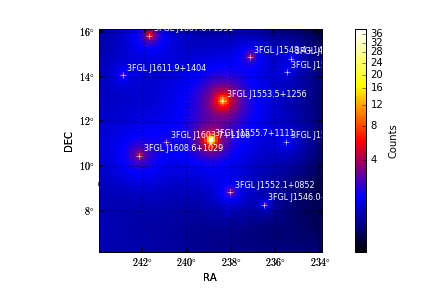

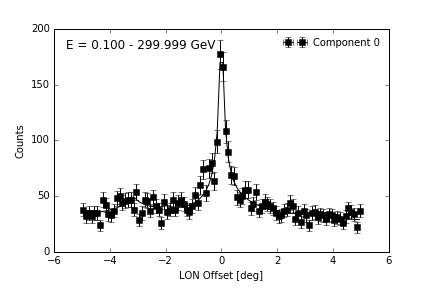

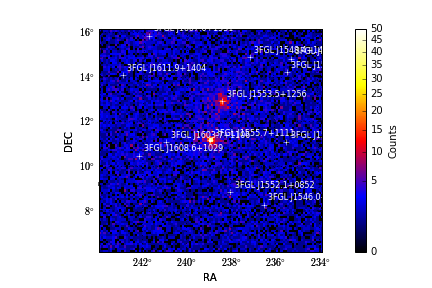

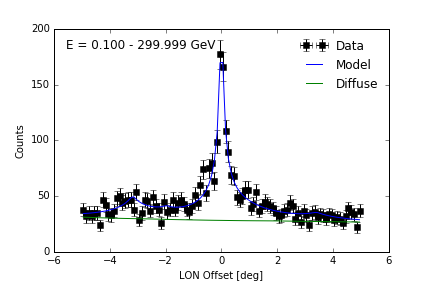

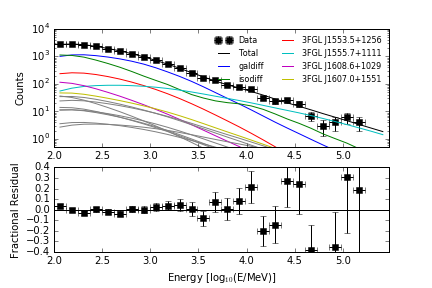

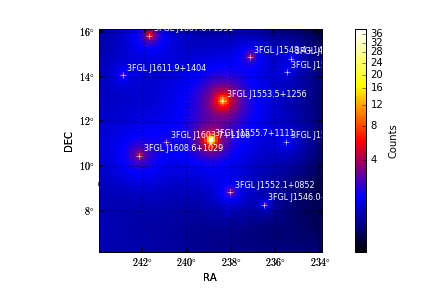

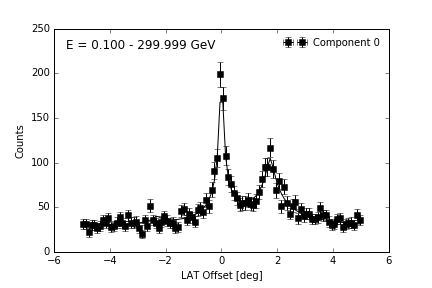

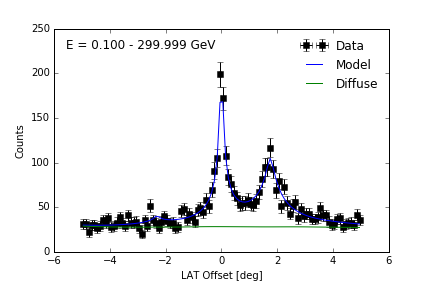

In [23]:
for png in pngs:
    my_image = Image(png)
    display(my_image)

### Reading in the results

Since the results are saved, you can load them back up at any point (you can also get to these within python).  Here we retrieve the analysis results from the output numpy file. 

In [51]:
c = np.load('pg1553/fit0.npy').flat[0]

Here's all the info that you have access to.

In [52]:
c['sources']['3FGL J1555.7+1111'].keys()

['eflux100',
 'Source_Name',
 'flux10000',
 'lnlprofile',
 'eflux10000_ul95',
 'spatial_pars',
 'SpatialModel',
 'flux10000_ul95',
 'flux100',
 'flux100_ul95',
 'flux_ul95',
 'offset_dec',
 'dfde1000',
 'ts',
 'class',
 'eflux10000',
 'params',
 'offset_glat',
 'dfde100',
 'eflux100_ul95',
 'offset_ra',
 'ra',
 'SpatialType',
 'offset_glon',
 'glon',
 'model_flux',
 'SpatialWidth',
 'eflux1000',
 'DEJ2000',
 'eflux',
 'glat',
 'dfde',
 'covar',
 'SpectrumType',
 'catalog',
 'assoc',
 'spectral_pars',
 'offset',
 'dfde10000',
 'eflux1000_ul95',
 'name',
 'flux1000_ul95',
 'flux1000',
 'SourceType',
 'extension',
 'eflux_ul95',
 'model_counts',
 'Npred',
 'flux',
 'RAJ2000',
 'sed',
 'pivot_energy',
 'dec']

Let's take a look at the flux, spectral parameters, and TS.

In [53]:
c['sources']['3FGL J1555.7+1111']['flux']

array([  6.17379656e-08,   6.16059393e-09])

In [54]:
c['sources']['3FGL J1555.7+1111']['params']

{'Eb': array([ 1491.38049316,            nan]),
 'alpha': array([ 1.53173542,  0.05066411]),
 'beta': array([ 0.04372217,  0.01761267]),
 'norm': array([  6.11726875e-12,   3.06869474e-13]),
 'spectrum_type': 'LogParabola'}

In [55]:
c['sources']['3FGL J1555.7+1111']['ts']

3003.9580848564656

The SED is in there as well.  We can plot it.

In [56]:
E = np.array(c['sources']['3FGL J1555.7+1111']['model_flux']['ecenter'])
dfde = np.array(c['sources']['3FGL J1555.7+1111']['model_flux']['dfde'])
dfde_hi = np.array(c['sources']['3FGL J1555.7+1111']['model_flux']['dfde_hi'])
dfde_lo = np.array(c['sources']['3FGL J1555.7+1111']['model_flux']['dfde_lo'])

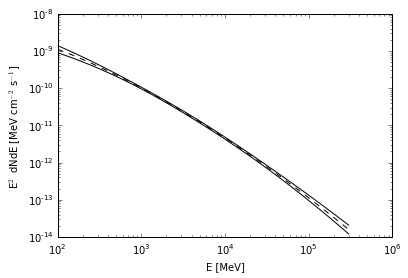

In [57]:
plt.loglog(10**E, (E**2)*dfde, 'k--')
plt.loglog(10**E, (E**2)*dfde_hi, 'k')
plt.loglog(10**E, (E**2)*dfde_lo, 'k')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^2$ dNdE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

If you want SED points, there's a function for that.  There are lots of options for this which you can set in the config file or from keyword arguments of the function itself.

In [61]:
sed = gta.sed('3FGL J1555.7+1111')

2015-11-15 00:07:52 - GTAnalysis - INFO - Computing SED for 3FGL J1555.7+1111


You can save the state to the yaml file or you can just access it directly.  This is also the way to get at the dictionary for any individual source.

In [59]:
src = gta.roi['3FGL J1555.7+1111']

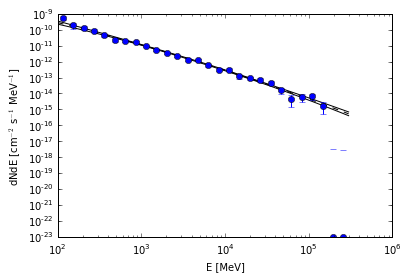

In [60]:
plt.loglog(10**E, dfde, 'k--')
plt.loglog(10**E, dfde_hi, 'k')
plt.loglog(10**E, dfde_lo, 'k')
plt.errorbar(10**np.array(src.data['sed']['ecenter'])
             ,src.data['sed']['dfde'], 
             yerr=src.data['sed']['dfde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'dNdE [cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
plt.show()

Looks like those last two points should be upper limits.  Let's plot those instead.

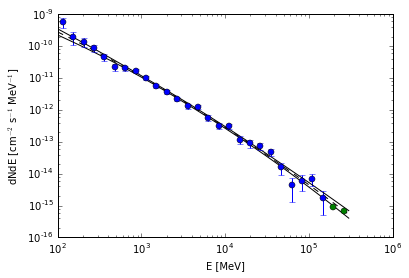

In [37]:
plt.loglog(10**E, dfde, 'k--')
plt.loglog(10**E, dfde_hi, 'k')
plt.loglog(10**E, dfde_lo, 'k')
plt.errorbar(10**np.array(src.data['sed']['ecenter'][:-2])
             ,src.data['sed']['dfde'][:-2], 
             yerr=src.data['sed']['dfde_err'][:-2], fmt ='o')
plt.plot(10**np.array(src.data['sed']['ecenter'][-2:])
             ,src.data['sed']['dfde_ul95'][-2:], 'o')
plt.xlabel('E [MeV]')
plt.ylabel(r'dNdE [cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
plt.show()

### Summary

There is a lot of other functionality and you should look through the docs for more details.  You can also inspect the GTAnalysis object for some of these (like TS Maps, extension tests, and using event types).  Advanced threads are coming.

* [IC443](ic443.ipynb) : Demonstration of an analysis to measure angular extension.
* [Draco](draco.ipynb) : Upper limit analysis of the Draco dwarf spheroidal galaxy.